## BiCycleGAN - Paper - Toward Multimodal Image-to-Image Translation - PyTorch Implementation from Scratch

## About the Satellite to Map Image Translation Dataset

This is a dataset comprised of satellite images of New York and their corresponding Google maps pages. The image translation problem involves converting satellite photos to Google maps format, or the reverse, Google maps images to Satellite photos.

The dataset is provided on the pix2pix website and can be downloaded as a 255-megabyte zip file.

maps

├── train

└── val

The train folder contains 1,097 images, whereas the validation dataset contains 1,099 images.

Images have a digit filename and are in JPEG format. Each image is 1,200 pixels wide and 600 pixels tall and contains both the satellite image on the left and the Google maps image on the right.

In [34]:
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import glob
import random
from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg  # This line imports matplotlib.image as mpimg
from IPython.display import clear_output
from icecream import ic

In [8]:
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    batch_size=8,        
    dataset_train_mode="train",
    dataset_test_mode="val",    
    lr=.0002,    
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    latent_dim=8,
    n_critic=5,
    sample_interval=400,
    lambda_pixel=10,
    lambda_latent=.5,
    lambda_kl=.01)

img_root_folder = '/kaggle/input/maps-dataset/maps'

In [10]:
class ImageDataset(Dataset):
    """
    Custom dataset class for loading and processing images for the BiCycleGAN project.
    
    Args:
        root (str): Root directory containing the image files.
        transforms_ (list): List of torchvision.transforms to apply to the images.
        mode (str): Dataset mode, either "train" or "test".
    """
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)

        # Using the glob and sorted functions to load all the images and sort them.
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))
            # `extends()` method adds the specified list elements to the end of the current list.

    def __getitem__(self, index):
        """
        Get an item from the dataset.
        
        Args:
            index (int): Index of the item to retrieve.
        
        Returns:
            dict: Dictionary containing the transformed images.
        """

        img = Image.open(self.files[index % len(self.files)])
        ''' In above line, my target is to find index item in a list based on the length of a variable in the list
        So, in case such indexes do not exist, None is returned. 
        a % b => a is divided by b, and the remainder of that division is returned.
        5 % 100 => 5 '''
        w, h = img.size # Pillow.Image.open() returns width, height
        img_A = img.crop((0, 0, w / 2, h)) # (left, upper, right, lower)
        img_B = img.crop((w / 2, 0, w, h)) # (left, upper, right, lower)        

        ''' Below code block implements Horizontal Flipping or Mirroring Image based on randomly generated probability '''
        if np.random.random() < 0.5:
            # Converting from numpy arrays to a RGB image
            # Call PIL.Image.fromarray(obj, mode) with obj as a 3-D array and mode as "RGB" to convert obj into an image.
            # Image.fromarray creates an image memory from an object exporting the array interface
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB") # Mirror in x direction (flip horizontally)
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB") # Mirror in x direction (flip horizontally)
            ''' a[::-1]    # all items in the array, reversed. 
            Pillow image returns tuple of (width, height)    
            The data has 3 dimensions: height, width and color. Numpy shape of the image is a tuple of (row (height), column (width), color(3) )
            So ::-1 effectively reverses the order of the width. The height and color are not affected.
            '''

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        """
        Get the length of the dataset.
        
        Returns:
            int: Length of the dataset.
        """
        return len(self.files)

### Explanation of Horizontal Image Flipping with `Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")`

Basically, its implementing, the official code's mechanism

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/data/base_dataset.py#L144

```py
def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return 

```

#### Note - numpy arrays and PIL images have different shape, in Numpy its (H,W) and in PIL and (W,H)

===========================================================================

#### Why `img = Image.open(self.files[index % len(self.files)])`

Because, here my target is to find index item in a list based on the length of a variable in the list

So, in case such indexes do not exist, None is returned. 

In [12]:
#  IMAGE VISUALIZER HELPERS
def imshow(img, size=10):
    """
    Display an image using matplotlib.

    Args:
        img (torch.Tensor): Input image tensor.
        size (int, optional): Size of the displayed figure. Defaults to 10.
    """
    img = img / 2 + 0.5  # de-normalizing
    npimg = img.numpy()
    plt.figure(figsize=(size, size))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualise_output(path, x, y):
    """
    Load and display an image using matplotlib.

    Args:
        path (str): Path to the image file.
        x (int): Width of the displayed figure.
        y (int): Height of the displayed figure.
    """
    img = mpimg.imread(path)
    plt.figure(figsize=(x, y))
    plt.imshow(img)
    plt.show()


## Explanation of line `img = img / 2 + 0.5`  # de-normalizing

Since the normalization process is actually z = (x - mean) / sigma 

Where both mean and sigma is 0.5

The inverse normalization should be x = z*sigma + mean


https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/7

In [13]:
#  CONFIGURE DATALOADERS
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataloader = DataLoader(
    ImageDataset(img_root_folder, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(img_root_folder, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

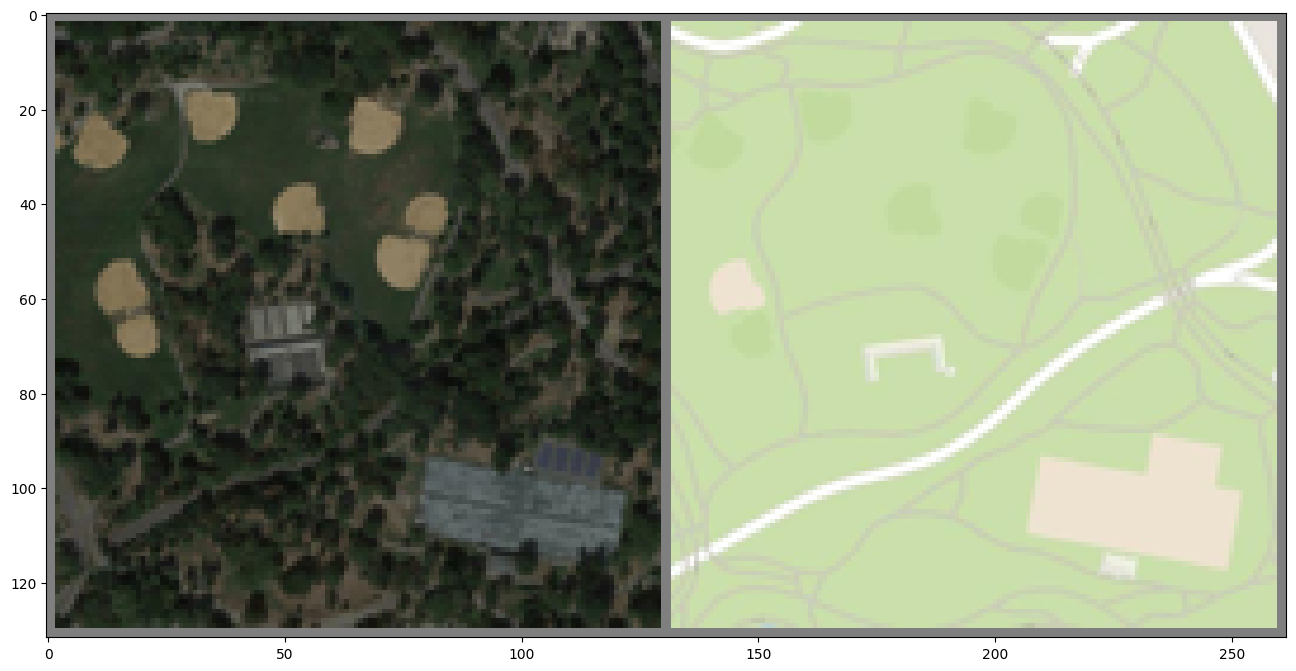

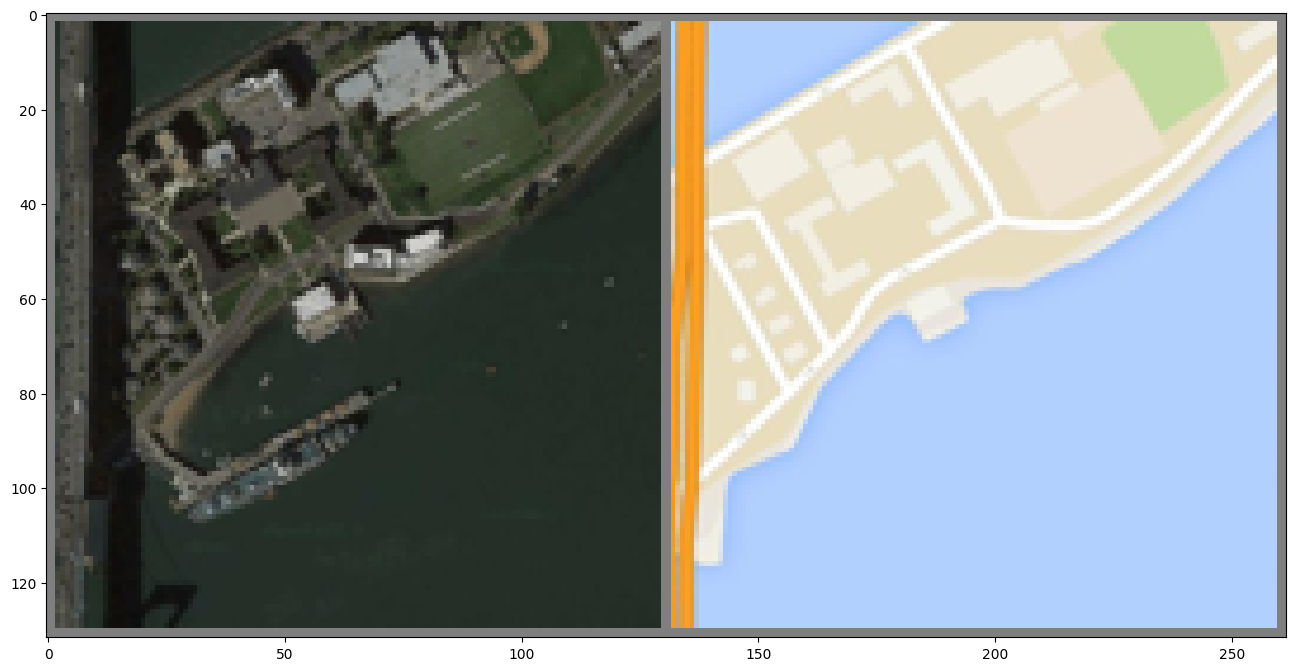

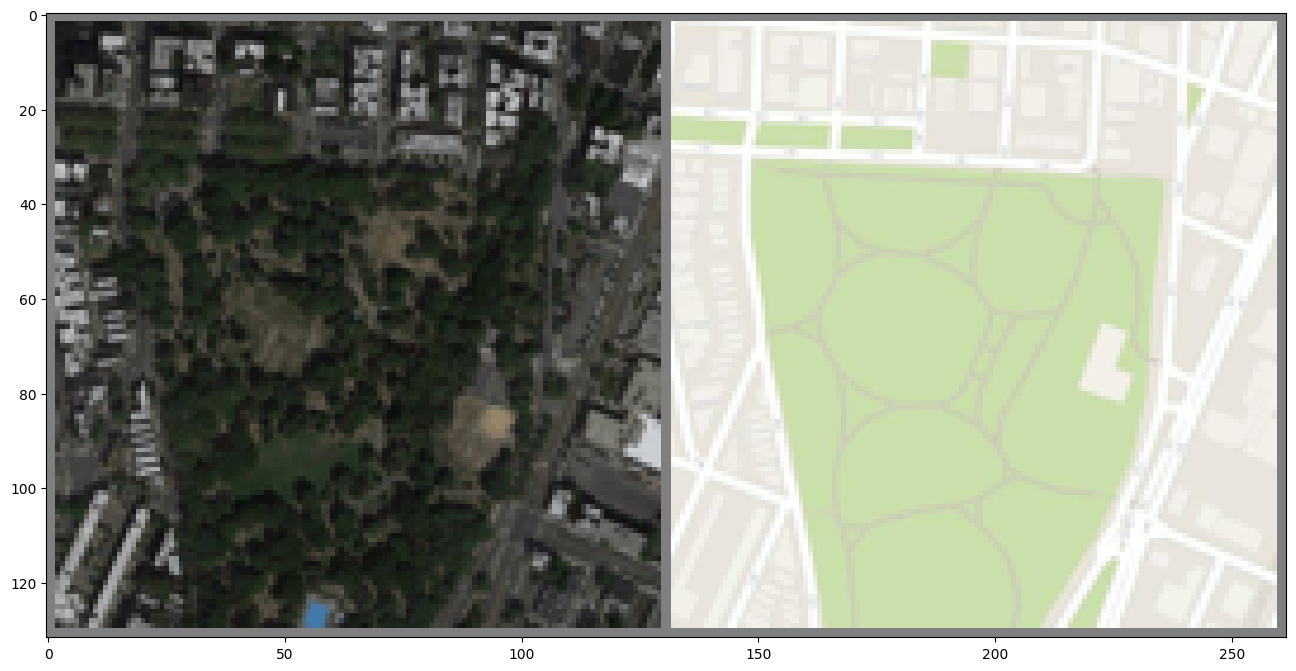

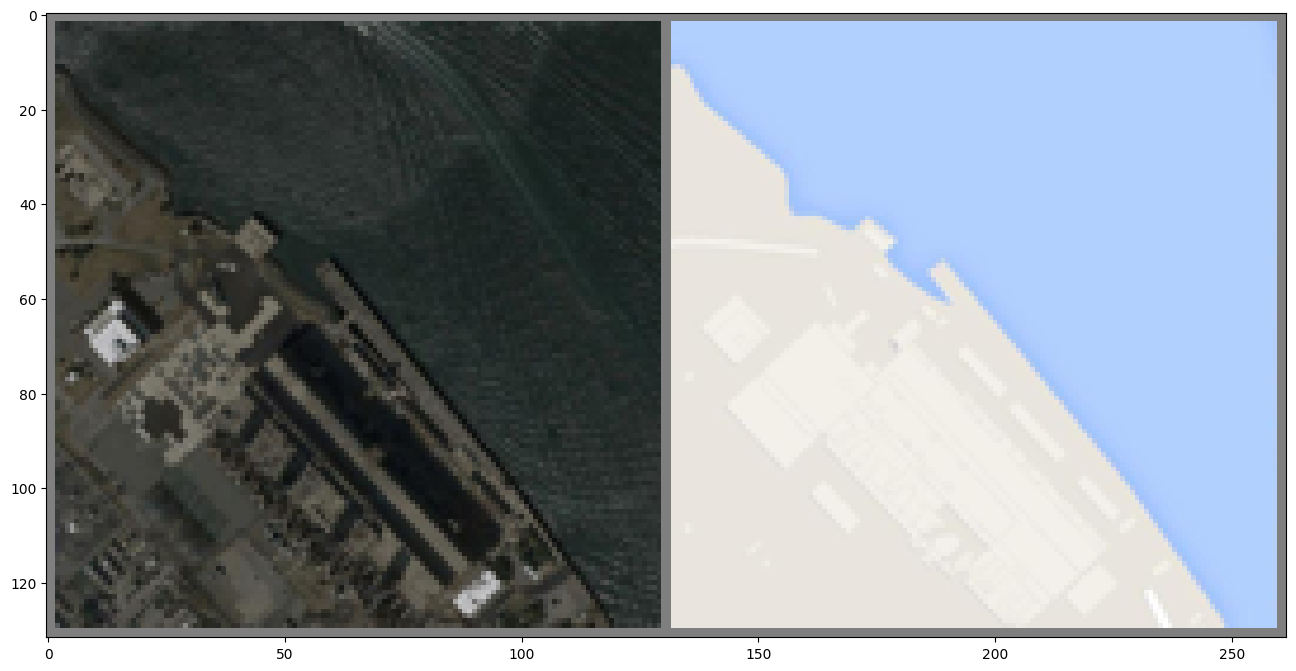

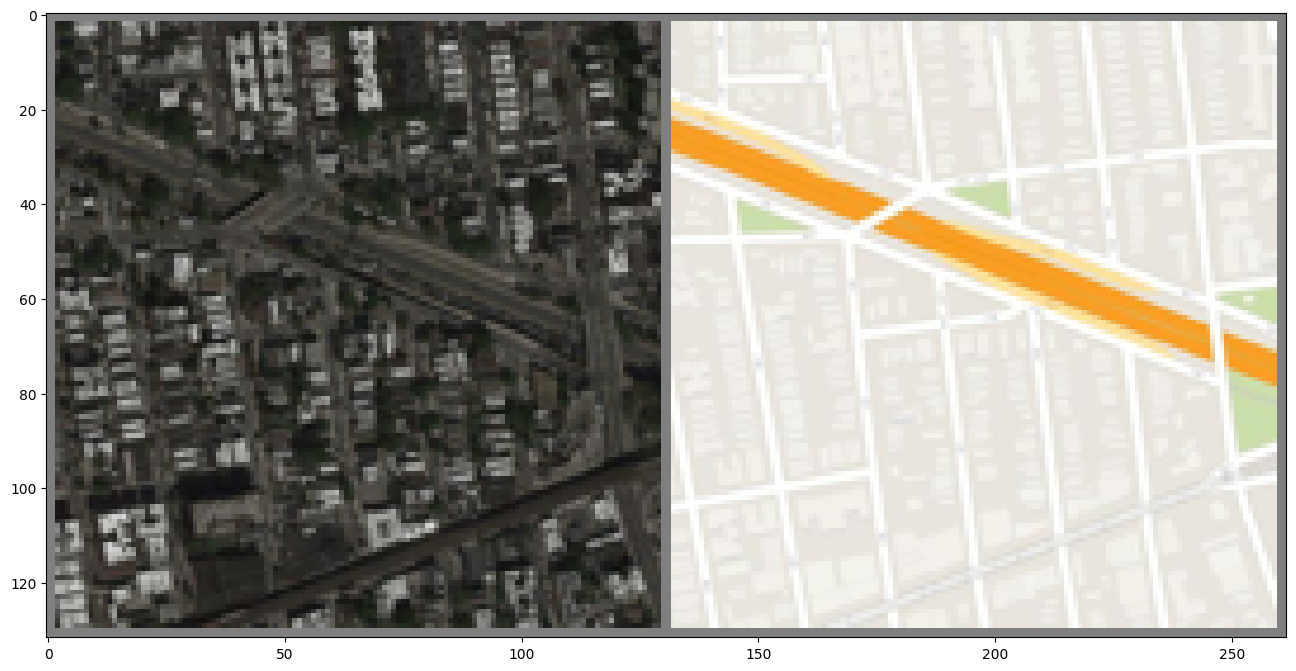

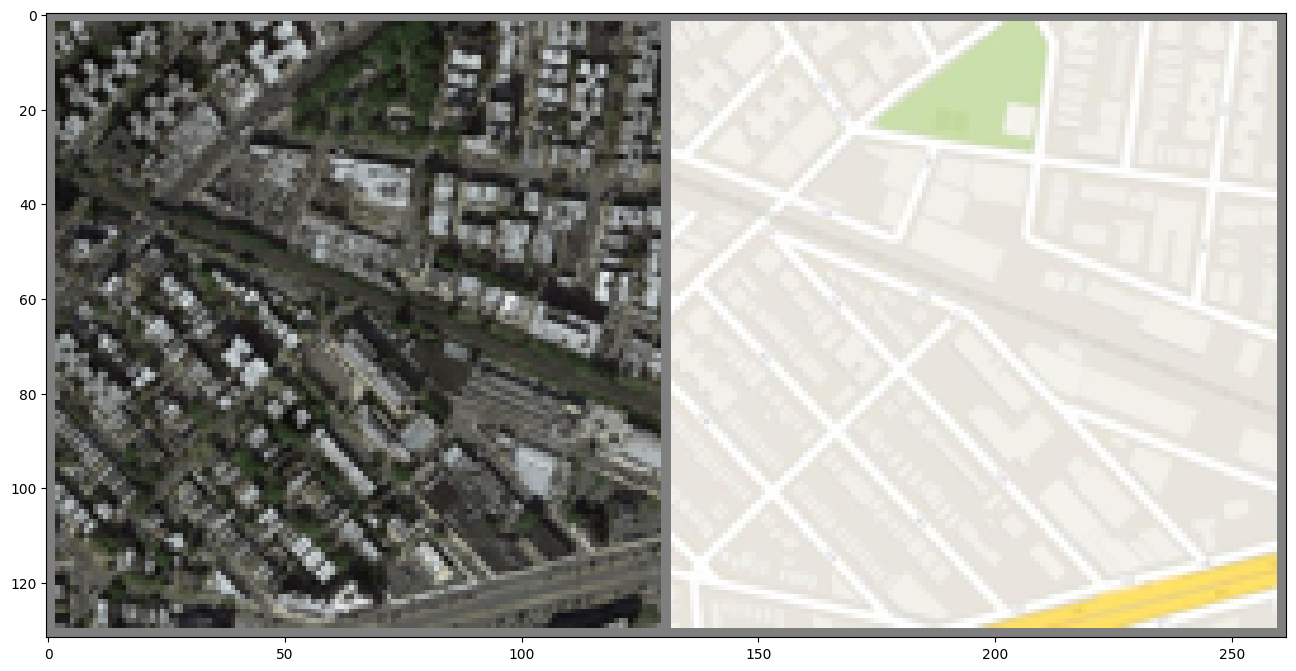

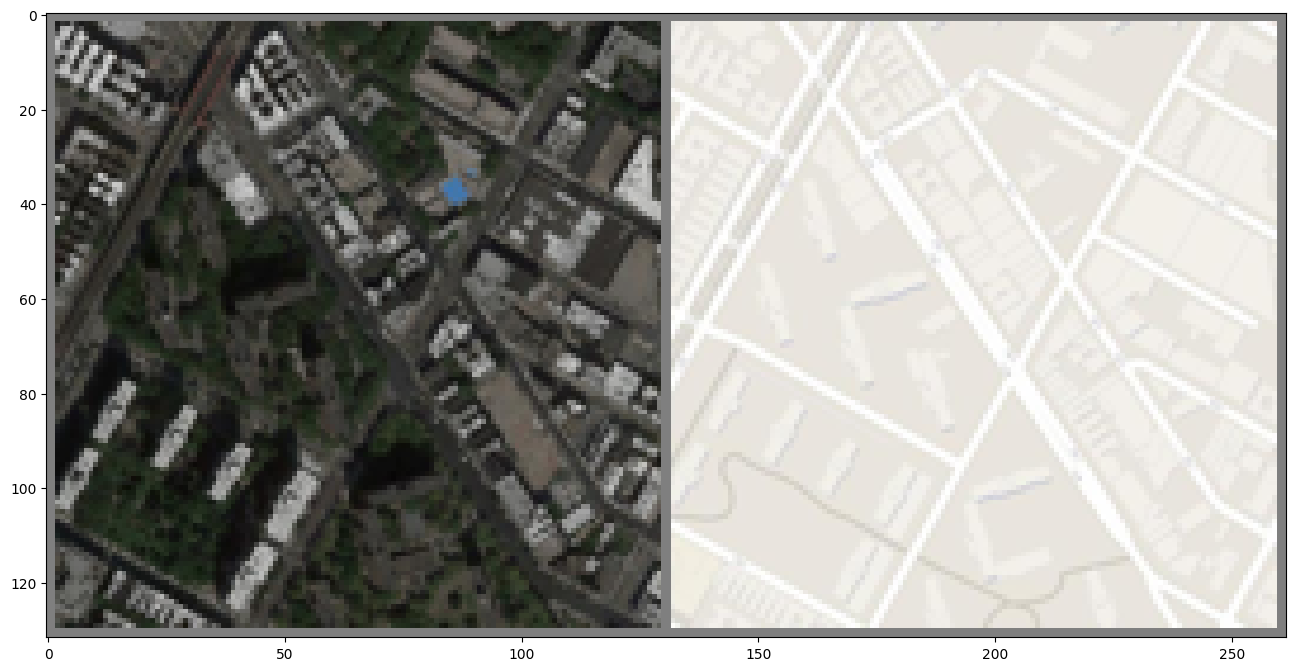

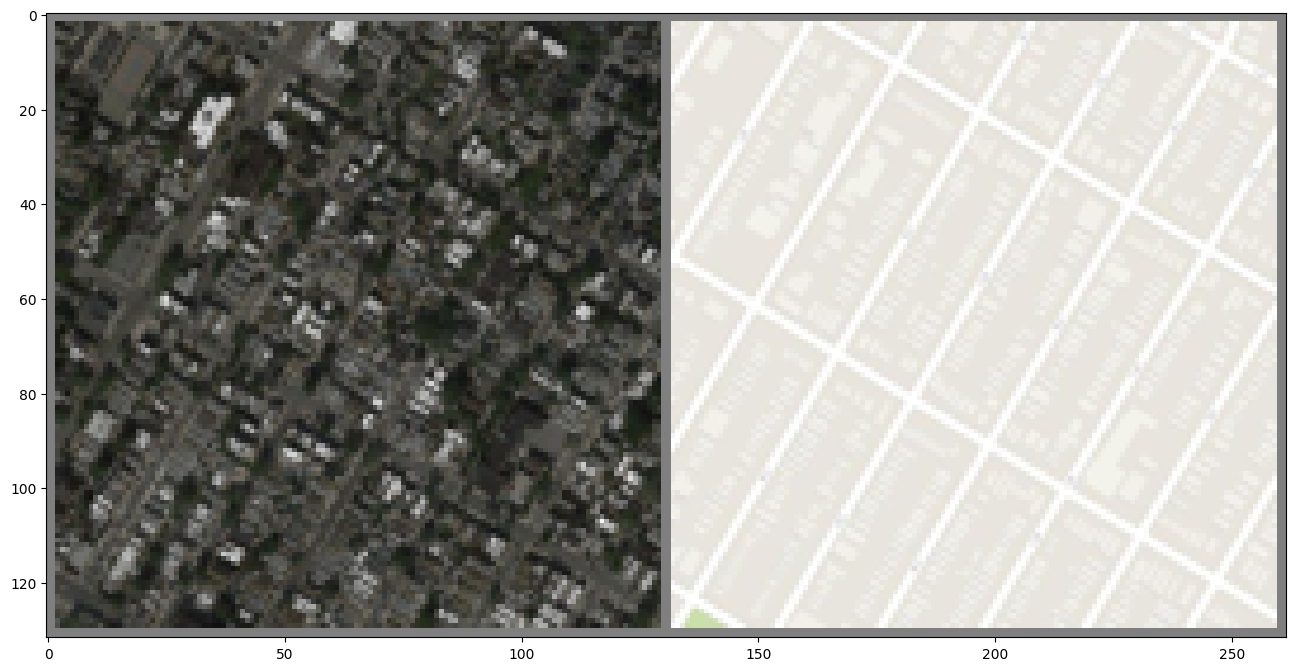

In [15]:
# VISUALING SAMPLE DATA { run: "auto" }
pic_size = 16

dataiter = iter(train_dataloader)
images = next(dataiter)

for i in range(len(images["A"])):
    imshow(make_grid([images["A"][i], images["B"][i]]), size=pic_size)

## Unet

Unet is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

The left hand side is the contraction path (Encoder) where we apply regular convolutions and max pooling layers.

In the Encoder, the size of the image gradually reduces while the depth gradually increases. (e.g. Starting from 128x128x3 to 8x8x256 )


The right hand side is the expansion path (Decoder) where we apply transposed convolutions along with regular convolutions

In the decoder, the size of the image gradually increases and the depth gradually decreases.

In [17]:
from torchvision.models import resnet18

########################################################
# Initialize convolution layer weights to N(0,0.02)
########################################################
def weights_init_normal(m):
    """
    Initialize the weights of a convolutional layer using a normal distribution.

    Args:
        m (torch.nn.Module): The module to initialize the weights for.
    """
    classname = m.__class__.__name__
    
    if classname.find("Conv") != -1:
        # Initialize the convolutional layer weights with a normal distribution (mean=0, std=0.02)
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    elif classname.find("BatchNorm2d") != -1:
        # Initialize the weights of the batch normalization layer with a normal distribution (mean=1, std=0.02)
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        
        # Initialize the biases of the batch normalization layer with zeros
        torch.nn.init.constant_(m.bias.data, 0.0)



##############################
#           U-NET
##############################
'''  As per the Paper - "For generator G, we use the U-Net, which contains an encoder-decoder
architecture, with symmetric skip connections." 
In the Encoder, the size of the image gradually reduces while the depth gradually increases. 
'''

class UNetDown(nn.Module):
    """  Implements the downsampling layer of a U-Net architecture.

    Parameters
    ----------
    in_size : int
        The number of input channels.
    out_size : int
        The number of output channels.
    normalize : bool, optional
        If True, performs batch normalization.
    dropout : float, optional
        Dropout rate. """
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 3, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

''' In the decoder, the size of the image gradually increases and the depth gradually decreases. '''
class UNetUp(nn.Module):
    """
    Implements the upsampling layer of a U-Net architecture.

    Parameters
    ----------
    in_size : int
        The number of input channels.
    out_size : int
        The number of output channels.
    """
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2), # Upsampling by a scaling factor of 2
            nn.Conv2d(in_size, out_size, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_size, 0.8),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    """
    Implements the Generator class for a U-Net-based Generator.

    Parameters
    ----------
    latent_dim : int
        The dimensionality of the latent space.
    img_shape : tuple
        The dimensions of the input image. Should be in the format (channels, height, width).
    """
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        channels, self.h, self.w = img_shape

        self.fc = nn.Linear(latent_dim, self.h * self.w)

        self.down1 = UNetDown(channels + 1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        self.down7 = UNetDown(512, 512, normalize=False)
        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 512)
        self.up3 = UNetUp(1024, 512)
        self.up4 = UNetUp(1024, 256)
        self.up5 = UNetUp(512, 128)
        self.up6 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(128, channels, 3, stride=1, padding=1), nn.Tanh()
        )

    def forward(self, x, z):
        # Propagate noise through fc layer and reshape to img shape
        z = self.fc(z).view(z.size(0), 1, self.h, self.w)
        d1 = self.down1(torch.cat((x, z), 1))
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        u1 = self.up1(d7, d6)
        u2 = self.up2(u1, d5)
        u3 = self.up3(u2, d4)
        u4 = self.up4(u3, d3)
        u5 = self.up5(u4, d2)
        u6 = self.up6(u5, d1)

        return self.final(u6)


##############################
#        Encoder
##############################

class Encoder(nn.Module):
    """
        Encoder module used in BiCycleGAN project.
        
        Args:
            latent_dim (int): Dimensionality of the latent space.
            input_shape (tuple): Shape of the input image (channels, height, width).
        """
    # 1. Use this encoder and get mu and log_var
    # 2. std = exp(log_var / 2)
    # 3. random_z = N(0, 1)
    # 4. encoded_z = random_z * std + mu (Reparameterization trick)
    def __init__(self, latent_dim, input_shape):
        super(Encoder, self).__init__()
        resnet18_model = resnet18(pretrained=False)
        self.feature_extractor = nn.Sequential(*list(resnet18_model.children())[:-3])
        # [:-3] => Everything except the last 3 items
        self.pooling = nn.AvgPool2d(kernel_size=8, stride=8, padding=0)
        # Output is mu and log(var) for reparameterization trick used in VAEs
        # mu and logvar assigned the same value (the encoder’s last layer output)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, img):
        """
        Forward pass of the encoder.
        
        Args:
            img (torch.Tensor): Input image tensor (batch_size, channels, height, width).
        
        Returns:
            tuple: A tuple containing the mu and log(var) tensors.
        """
        out = self.feature_extractor(img)
        out = self.pooling(out)
        out = out.view(out.size(0), -1)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar


##############################
#        Discriminator
##############################

class MultiDiscriminator(nn.Module):
    def __init__(self, input_shape):
        """
        MultiDiscriminator module used in the BiCycleGAN project.
        
        Args:
            input_shape (tuple): Shape of the input image (channels, height, width).
        """
        super(MultiDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        channels, _, _ = input_shape
        # Extracts discriminator models
        self.models = nn.ModuleList()
        for i in range(3):
            self.models.add_module(
                "disc_%d" % i,
                nn.Sequential(
                    *discriminator_block(channels, 64, normalize=False),
                    *discriminator_block(64, 128),
                    *discriminator_block(128, 256),
                    *discriminator_block(256, 512),
                    nn.Conv2d(512, 1, 3, padding=1)
                ),
            )

        self.downsample = nn.AvgPool2d(channels, stride=2, padding=[1, 1], count_include_pad=False)

    def compute_loss(self, x, ground_truth):
        """
        Computes the mean squared error (MSE) loss between model output and ground truth.
        
        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).
            ground_truth (torch.Tensor): Ground truth scalar value (batch_size).
        
        Returns:
            torch.Tensor: The computed loss.
        """
        loss = sum([torch.mean((out - ground_truth) ** 2) for out in self.forward(x)])
        return loss

    def forward(self, x):
        """
        Forward pass of the MultiDiscriminator.
        
        Args:
            x (torch.Tensor): Input tensor (batch_size, channels, height, width).
        
        Returns:
            list: A list of discriminator outputs at different scales.
        """
        outputs = []
        for m in self.models:
            outputs.append(m(x))
            x = self.downsample(x)
        return outputs

In [18]:
##############################################
#  SETUP, LOSS, INITIALIZE MODELS and BUFFERS
##############################################
cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss functions
mae_loss = torch.nn.L1Loss()
input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator, encoder and discriminators
generator = Generator(hp.latent_dim, input_shape)
encoder = Encoder(hp.latent_dim, input_shape)

D_VAE = MultiDiscriminator(input_shape)
D_LR = MultiDiscriminator(input_shape)

if cuda:
    generator = generator.cuda()
    encoder.cuda()
    D_VAE = D_VAE.cuda()
    D_LR = D_LR.cuda()
    mae_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
D_VAE.apply(weights_init_normal)
D_LR.apply(weights_init_normal)

Using CUDA


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultiDiscriminator(
  (models): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (downsample): AvgPool2d(kernel_size=3, stride=2, padding=[1, 1])
)

## Sampling Images

In [32]:
# Ensure directories are created
def sample_images(batches_done):
    """
    From the validation set this method will create images and
    save those Generated samples in a path
    """
    generator.eval()
    imgs = next(iter(val_dataloader))
    img_samples = None
    # Ensure the output directory exists
    output_dir = "/kaggle/working/content/maps"
    os.makedirs(output_dir, exist_ok=True)
    path = f"{output_dir}/{batches_done}.png"
    
    for img_A, img_B in zip(imgs["A"], imgs["B"]):
        # Repeat input image by number of desired columns
        real_A = img_A.view(1, *img_A.shape).repeat(hp.latent_dim, 1, 1, 1)
        real_A = Variable(real_A.type(Tensor))
        # Sample latent representations
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (hp.latent_dim, hp.latent_dim))))
        # Generate samples
        fake_B = generator(real_A, sampled_z)
        # Concatenate samples horizontally
        fake_B = torch.cat([x for x in fake_B.data.cpu()], -1)
        img_sample = torch.cat((img_A, fake_B), -1)
        img_sample = img_sample.view(1, *img_sample.shape)
        # Concatenate with previous samples vertically
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)
    
    save_image(img_samples, path, nrow=8, normalize=True)
    generator.train() 
    return path

In [27]:
#  OPTIMIZERS
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## The reparameterization trick

#### The reparameterization trick is to learn two vectors σ and μ, 

First, sample ϵ from N(0,1) and then your latent vector Z would be (where ⊙ symbol or notation is the element-wise product.):

## Z = μ +  ϵ ⊙ σ


So, if an input data point is to be mapped into a latent variable `z` via sampling (after getting passed through a neural network), it has to follow the following equation:

## z = z_mean + epsilon * std 

where 

### std = torch.exp(z_log_var / 2)

----


## Reconciliation between 2 mathematical expression for z

## 1st  -> z = z_mean + epsilon * std

## 2nd (where the std is expressed as below )

![Imgur](https://imgur.com/1G3iT3m.png)


The σ in the first equation is the standard deviation which as you know is the square root of the variance. Then you can see that the multiplication of 0.5 outside the log equates to raising the variance inside of the log to the power of 0.5:


![Imgur](https://imgur.com/CQxP66m.png)


So they are the same.

In [28]:
'''  REPARAMETERIZE 

The reparameterization trick is to learn two vectors σ and μ, sample ϵ from N(0,1) and 
then your latent vector Z would be as below (where ⊙ is the element-wise product.):

z = μ +  ϵ ⊙  σ

z = z_mean +  epsilon * sigma

'''

def reparameterization(z_mean, z_log_var):
    """
    Reparameterization trick used in the BiCycleGAN project.
    
    Args:
        z_mean (torch.Tensor): Mean of the latent space (batch_size, latent_dim).
        z_log_var (torch.Tensor): Log variance of the latent space (batch_size, latent_dim).
    
    Returns:
        torch.Tensor: Sampled latent vectors using the reparameterization trick (batch_size, latent_dim).
    """
    std = torch.exp(z_log_var / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (z_mean.size(0), hp.latent_dim))))
    z = z_mean + sampled_z * std
    return z

So in above implementation the `sampled_z` is replacing 'epsilon'



### `np.random.normal()`

The `random.normal` method has the following syntax:

`numpy.random.normal(m,s,n)`

The random.normal function takes in three parameters:

* m: the mean of the normal distribution.
* s: the standard deviation of the distribution.
* n: the total number of samples to be drawn.

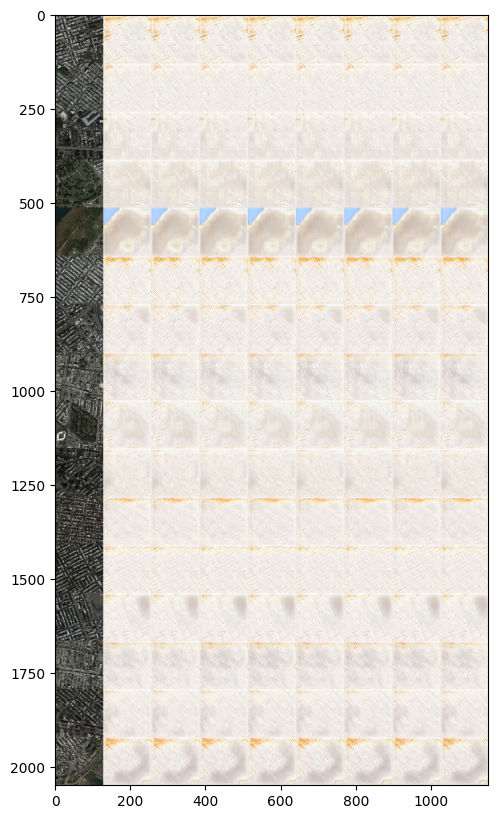

[Epoch 33/200] [Batch 96/137] [D VAE_loss: 0.735180, LR_loss: 0.316529] [G loss: 6.784744, pixel: 0.124593, kl: 0.155647, latent: 0.430725] ETA: 1:22:49.6420395

In [ ]:
#  TRAINING
# Adversarial loss
valid = 1
fake = 0

prev_time = time.time()
for epoch in range(hp.epoch, hp.n_epochs):
    for i, batch in enumerate(train_dataloader):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        ################################
        #  Train Generator and Encoder
        #################################
        '''  The first component of Bicycle-GAN is cVAE-GAN. It first encodes the ground truth image(B) into the latent space using encoder E.

        ### Then input image(A) and encoded ground truth image(i.e. latent vector - Z) are passed into the Generator G which produces the output image(B^). That is, The generator attempts to map the input image A along with a sampled z back into the original image B.
        the flow of cVAE-GAN => B -> Z -> B^
        '''

        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        #################
        # cVAE-GAN
        #################

        # Produce output using encoding of B (cVAE-GAN)
        mu, logvar = encoder(real_B)
        # reparameterize so backprogation can be done on the
        # stochastically generated z variable
        encoded_z = reparameterization(mu, logvar)
        fake_B = generator(real_A, encoded_z)

        # Pixelwise loss of translated image by VAE
        loss_pixel_L1_vae = mae_loss(fake_B, real_B)
        
        # Kullback-Leibler divergence of encoded B
        # Refer - https://stackoverflow.com/questions/61597340/how-is-kl-divergence-in-pytorch-code-related-to-the-formula
        loss_kl = 0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - logvar - 1)
        # Adversarial loss
        # compute_loss() - Computes the MSE between model output and scalar ground_truth
        loss_VAE_GAN = D_VAE.compute_loss(fake_B, valid)

        ####################################
        # cLR-GAN
        # Conditional Latent Regressor GAN
        ####################################
        
        ''' This is the second component of the Bicycle-GAN. Here a randomly drawn latent vector (sampled_z below) along with the input image(A) is provided to the generator. The generated output(B^) may not look like ground truth image(B), but it should look realistic.
        Then the generated output is passed through the encoder, encoder tries to regain the latent vector from the output image. 
        
        the flow of cLR-GAN is Z -> B^ -> Z^
        '''

        # real_A need to be a 4-D Tensor of Batch_size, Channel, Height, Width
        # ic(real_A.size()) # torch.Size([8, 3, 128, 128])
        # Produce output using sampled z (cLR-GAN)
        # sampled_z need to be a 2-D Tensor of Batch_size (i.e. 8) and Latent_dim (i.e 8)
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (real_A.size(0), hp.latent_dim))))
        # Draw random samples from a normal (Gaussian) distribution.
        # ic(sampled_z.size()) # torch.Size([8, 8])
        ''' ic(sampled_z) will output below
        tensor([[ 0.2202,  0.3848, -1.0489, -0.5884, -0.0094,  0.1678, -1.5106, -0.2802],
                       [ 1.9893, -0.8738, -2.4284,  1.0219,  0.4162,  0.3345, -1.7501,  0.0511],
                       [-0.5878,  0.0200, -0.9107,  0.8697, -1.8777,  0.3819,  0.4788, -3.0111],
                       [ 0.9784,  0.7068, -0.2902,  0.9084,  0.2643, -0.0090,  0.6117, -1.4820],
                       [-0.1651, -0.5930,  0.1434,  1.6912, -0.6974, -1.7704, -3.2449, -0.4491],
                       [-1.1474, -1.6918,  1.6326, -0.7691,  0.4847,  2.0244, -0.3476, -1.1350],
                       [ 0.3965,  0.3789,  0.3177, -1.5840,  0.6150, -1.4996,  0.2707, -0.7499],
                       [-0.1608, -0.8812, -0.0048, -0.6618, -0.5037, -0.8252,  0.7017,  0.4248]],
                      device='cuda:0') '''
        
        _fake_B = generator(real_A, sampled_z)
        # cLR Loss: Adversarial loss
        loss_CLR_GAN = D_LR.compute_loss(_fake_B, valid)

        #########################################
        # Total Loss (Generator + Encoder)
        #########################################

        loss_total_gen_encoder = loss_VAE_GAN + loss_CLR_GAN + hp.lambda_pixel * loss_pixel_L1_vae + hp.lambda_kl * loss_kl

        loss_total_gen_encoder.backward(retain_graph=True)
        optimizer_E.step()

        ######################
        # Generator Only Loss
        ######################
        '''Under CLR-GAN - Then the generated output (_fake_B) is passed through the encoder, encoder tries to regain the latent vector from the output image. '''

        # Latent L1 loss
        _mu, _ = encoder(_fake_B)
        loss_latent = hp.lambda_latent * mae_loss(_mu, sampled_z)

        loss_latent.backward()
        optimizer_G.step()

        #######################################
        #  Train Discriminator (cVAE-GAN)
        #######################################

        optimizer_D_VAE.zero_grad()

        loss_D_VAE = D_VAE.compute_loss(real_B, valid) + D_VAE.compute_loss(fake_B.detach(), fake)

        loss_D_VAE.backward()
        optimizer_D_VAE.step()

        ####################################
        # Train Discriminator (cLR-GAN)
        # Conditional Latent Regressor GAN
        ####################################

        optimizer_D_LR.zero_grad()

        loss_D_LR = D_LR.compute_loss(real_B, valid) + D_LR.compute_loss(_fake_B.detach(), fake)

        loss_D_LR.backward()
        optimizer_D_LR.step()

        #################
        #  Log Progress
        #################

        # Determine approximate time left
        batches_done = epoch * len(train_dataloader) + i
        batches_left = hp.n_epochs * len(train_dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D VAE_loss: %f, LR_loss: %f] [G loss: %f, pixel: %f, kl: %f, latent: %f] ETA: %s"
            % (
                epoch,
                hp.n_epochs,
                i,
                len(train_dataloader),
                loss_D_VAE.item(),
                loss_D_LR.item(),
                loss_total_gen_encoder.item(),
                loss_pixel_L1_vae.item(),
                loss_kl.item(),
                loss_latent.item(),
                time_left,
            )
        )
        # If at sample interval save image
        if batches_done % hp.sample_interval == 0:
            clear_output()
            visualise_output(sample_images(batches_done), 30, 10)   

In [37]:
def save_models(generator, encoder, D_VAE, D_LR, epoch, save_dir="/kaggle/working/models"):
    """
    Save the trained models to the specified directory.

    Args:
        generator (nn.Module): Trained generator model.
        encoder (nn.Module): Trained encoder model.
        D_VAE (nn.Module): Trained VAE discriminator model.
        D_LR (nn.Module): Trained LR discriminator model.
        epoch (int): Current epoch number.
        save_dir (str): Directory where the models will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    torch.save(generator.state_dict(), os.path.join(save_dir, f"generator_{epoch}.pth"))
    torch.save(encoder.state_dict(), os.path.join(save_dir, f"encoder_{epoch}.pth"))
    torch.save(D_VAE.state_dict(), os.path.join(save_dir, f"D_VAE_{epoch}.pth"))
    torch.save(D_LR.state_dict(), os.path.join(save_dir, f"D_LR_{epoch}.pth"))

# Example usage
epoch_to_save = hp.n_epochs
save_models(generator, encoder, D_VAE, D_LR, epoch_to_save)

In [ ]:
def load_models(generator, encoder, D_VAE, D_LR, epoch, save_dir="/kaggle/working/models"):
    """
    Load the saved models from the specified directory.

    Args:
        generator (nn.Module): Generator model to load state dict into.
        encoder (nn.Module): Encoder model to load state dict into.
        D_VAE (nn.Module): VAE discriminator model to load state dict into.
        D_LR (nn.Module): LR discriminator model to load state dict into.
        epoch (int): Epoch number of the models to load.
        save_dir (str): Directory where the models are saved.
    """
    generator.load_state_dict(torch.load(os.path.join(save_dir, f"generator_{epoch}.pth")))
    encoder.load_state_dict(torch.load(os.path.join(save_dir, f"encoder_{epoch}.pth")))
    D_VAE.load_state_dict(torch.load(os.path.join(save_dir, f"D_VAE_{epoch}.pth")))
    D_LR.load_state_dict(torch.load(os.path.join(save_dir, f"D_LR_{epoch}.pth")))

def test_models(generator, val_dataloader):
    """
    Test the generator on the validation set and display the results.

    Args:
        generator (nn.Module): Trained generator model.
        val_dataloader (DataLoader): DataLoader for the validation set.
    """
    generator.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            real_A = Variable(batch["A"].type(Tensor))
            # Generate a latent vector for each image
            latent_z = torch.randn(real_A.size(0), hp.latent_dim, device=Tensor.device)
            # Generate the map images
            generated_maps = generator(real_A, latent_z)
            # Display the images
            for j in range(len(generated_maps)):
                imshow(make_grid([real_A[j], generated_maps[j]], nrow=2), size=10)
                if i >= 5:  # Show only a few samples
                    break

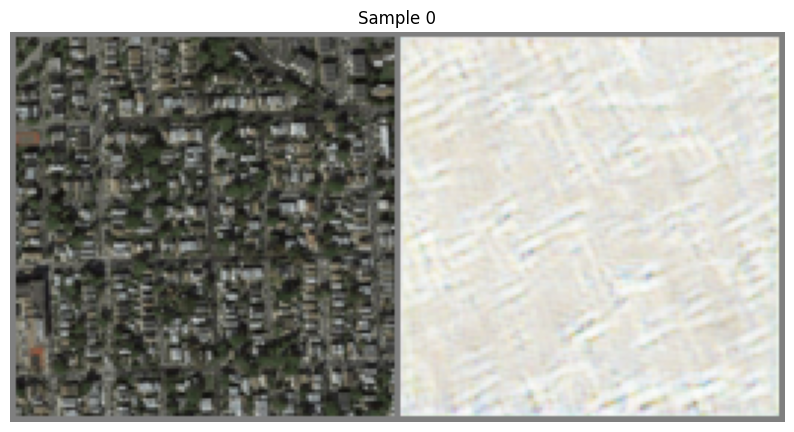

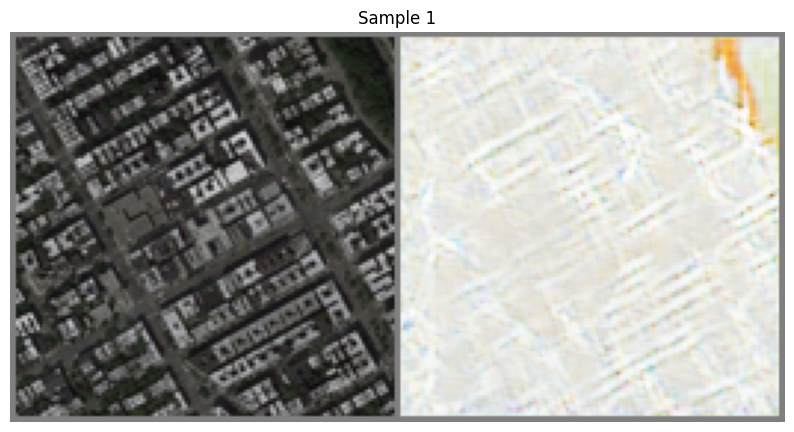

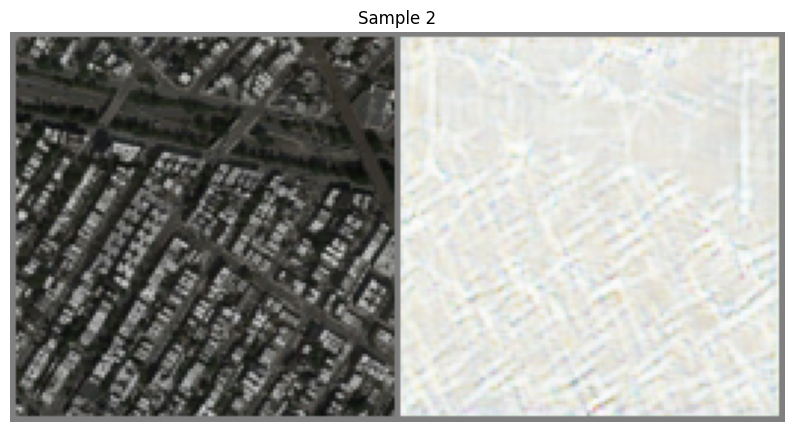

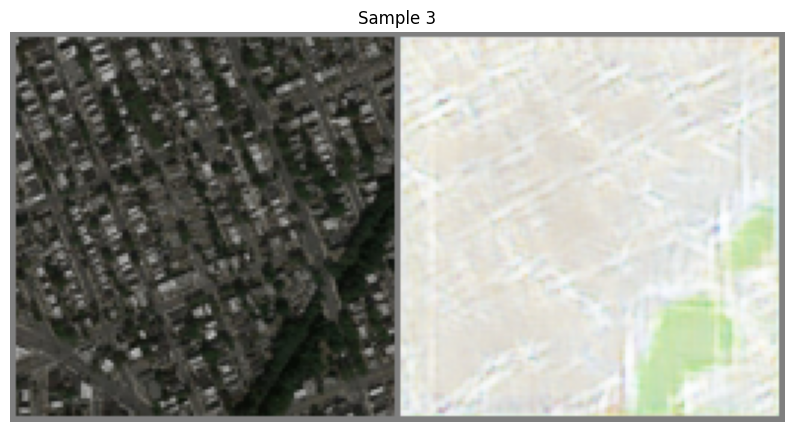

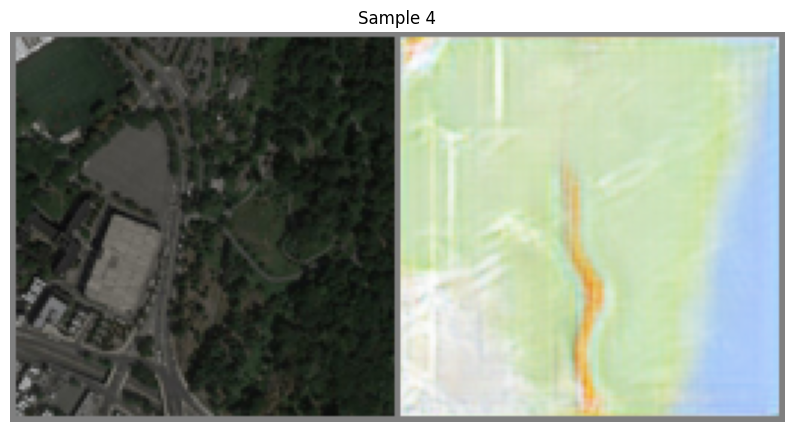

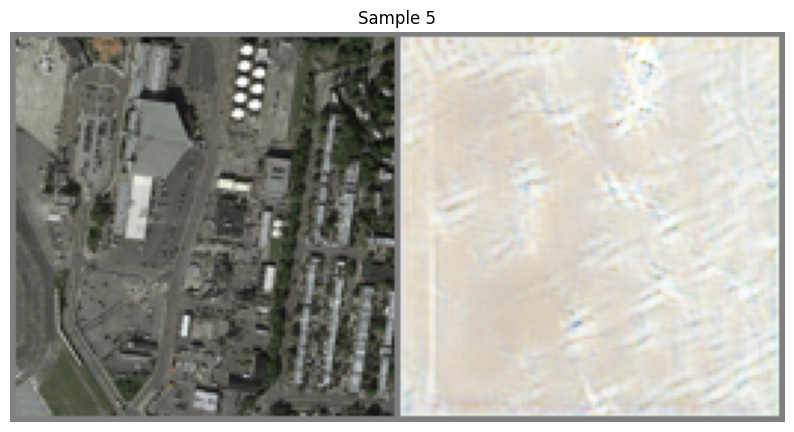

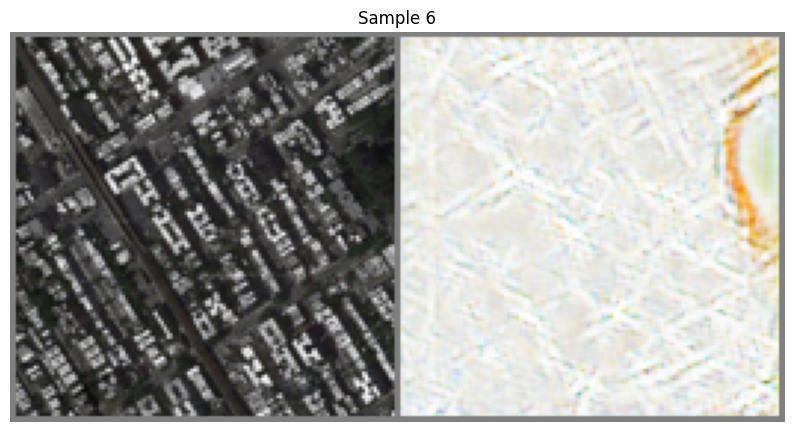

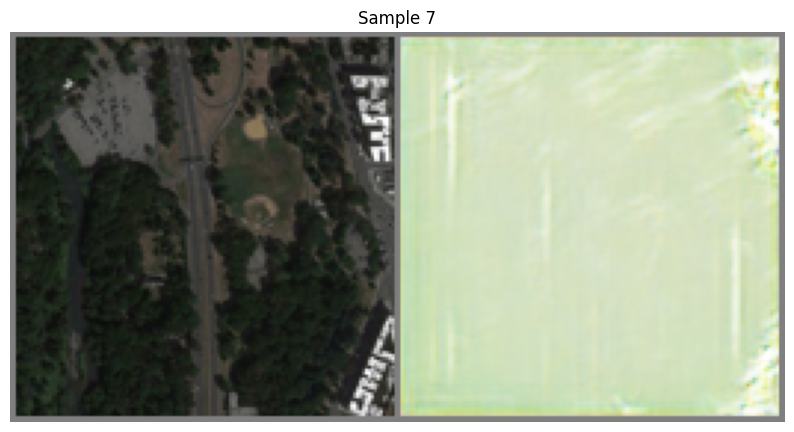

In [41]:
# import os
# import torch
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from torchvision.utils import make_grid
# import matplotlib.pyplot as plt
# from PIL import Image
# from torch.autograd import Variable

# Assuming hp and Tensor are already defined as in your setup

# Define a function to display images
def imshow(img, title=None):
    """Display an image with optional title."""
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Define a function to generate map images from satellite images
def generate_map_images(generator, data_loader, num_samples=5):
    """
    Generate map images from satellite images using the generator.

    Args:
        generator (nn.Module): Trained generator model.
        data_loader (DataLoader): DataLoader for the dataset.
        num_samples (int, optional): Number of samples to generate. Defaults to 5.
    """
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # No gradient calculation needed
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            real_A = Variable(batch["A"].type(Tensor))

            # Generate random latent vectors
            latent_z = torch.randn(real_A.size(0), hp.latent_dim, device=real_A.device)

            # Generate the map images
            generated_maps = generator(real_A, latent_z)

            # Show the images
            for j in range(len(generated_maps)):
                imshow(make_grid([real_A[j].cpu(), generated_maps[j].cpu()], nrow=2), title=f"Sample {i * len(generated_maps) + j}")

# Define the transformations applied to the images
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Initialize DataLoader with the ImageDataset
train_dataloader = DataLoader(
    ImageDataset(img_root_folder, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)

# Call the function to generate and display map images
generate_map_images(generator, train_dataloader, num_samples=1)

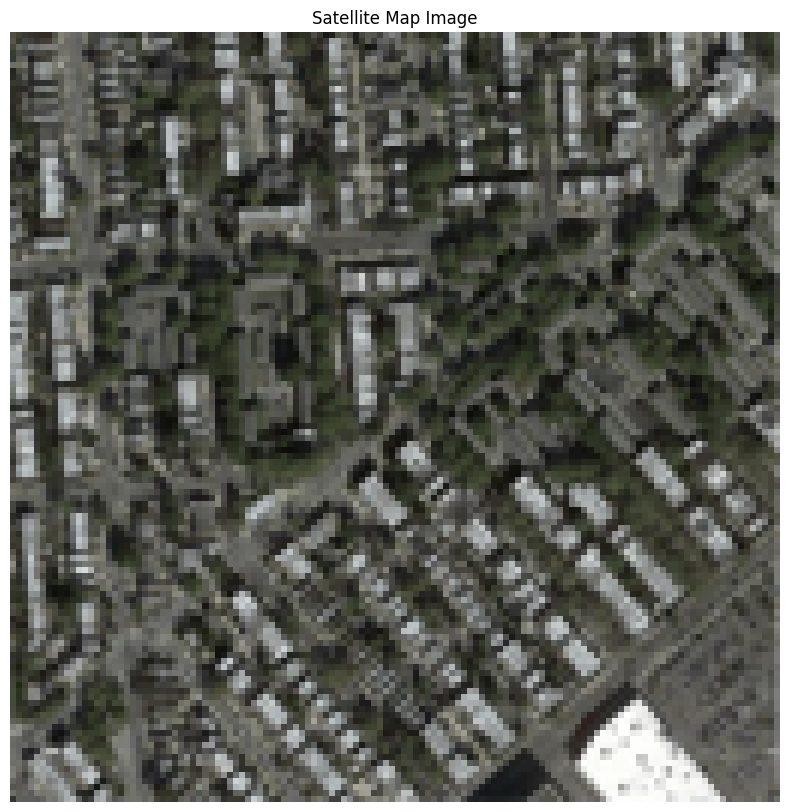

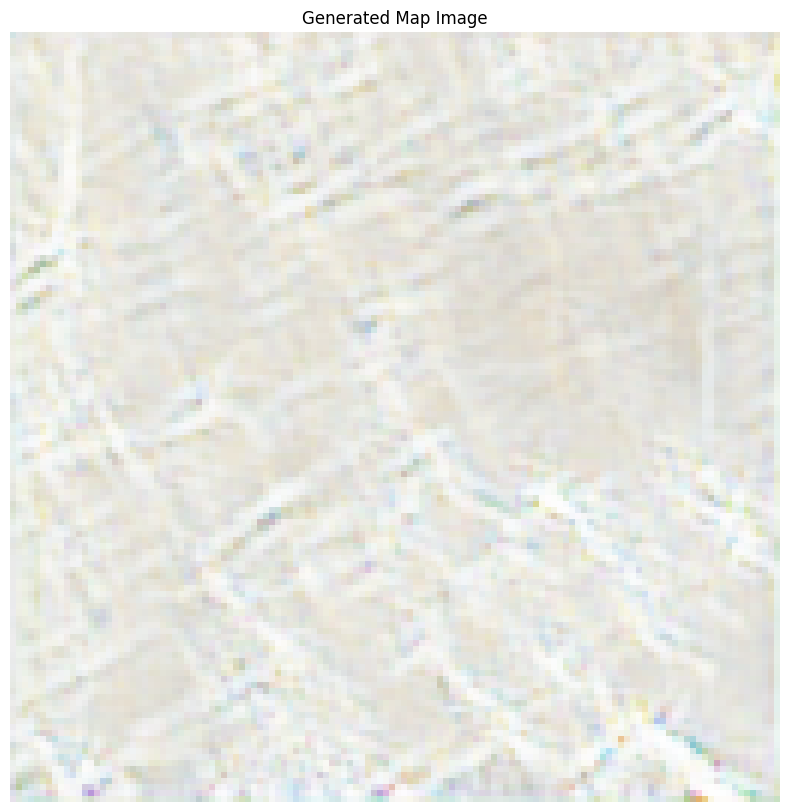

In [44]:
def generate_map_image(generator, satellite_image_path):
    """
    Generate a map image from a satellite image using the generator.

    Args:
        generator (nn.Module): Trained generator model.
        satellite_image_path (str): Path to the input satellite image.

    Returns:
        torch.Tensor: Generated map image tensor.
    """
    # Load and preprocess the satellite image
    satellite_image = Image.open(satellite_image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    satellite_tensor = preprocess(satellite_image).unsqueeze(0)  # Add batch dimension
    
    # Move the input to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    satellite_tensor = satellite_tensor.to(device)
    imshow(satellite_tensor.squeeze(0).cpu(), title="Satellite Map Image")
    
    # Generate the map image
    generator.eval()
    with torch.no_grad():
        latent_z = torch.randn(1, hp.latent_dim, device=device)  # Generate a random latent vector
        map_image_tensor = generator(satellite_tensor, latent_z)
    
    return map_image_tensor

# Example usage
satellite_image_path = '/kaggle/input/sample-satellite-maps/Screenshot 2024-08-16 at 1.05.38PM.png'
generated_map_image_tensor = generate_map_image(generator, satellite_image_path)

# Visualize the generated image
imshow(generated_map_image_tensor.squeeze(0).cpu(), title="Generated Map Image")

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 60.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.12.5
    Uninstalling tomlkit-0.12.5:
      Successfully uninstalled tomlkit-0.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is incom

In [3]:
import gradio as gr
# Define the transformations applied to the images
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

def generate_map_image(satellite_image):
    """
    Generate a map image from a satellite image using the generator.

    Args:
        satellite_image (PIL.Image): Input satellite image.

    Returns:
        PIL.Image: Generated map image.
    """
    # Preprocess the satellite image
    preprocess = transforms.Compose(transforms_)
    satellite_tensor = preprocess(satellite_image).unsqueeze(0)  # Add batch dimension

    # Move the input to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    satellite_tensor = satellite_tensor.to(device)

    # Generate the map image
    generator.eval()
    with torch.no_grad():
        latent_z = torch.randn(1, hp.latent_dim, device=device)  # Generate a random latent vector
        map_image_tensor = generator(satellite_tensor, latent_z)

    # Post-process and convert the output tensor to an image
    map_image_tensor = map_image_tensor.squeeze(0).cpu()
    map_image = transforms.ToPILImage()(map_image_tensor)
    
    return map_image

# Set up the Gradio interface
interface = gr.Interface(
    fn=generate_map_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="Satellite to Map Image Generator",
    description="Upload a satellite image to generate a corresponding map image."
)

# Launch the Gradio interface
interface.launch()

NameError: name 'transforms' is not defined